# Load Model

In [2]:
# Params
import os
config_path = '/home/lolicon/workspace/CS-Project/configs/multi-cldm_v15-lora.yaml'
root_dir = '/home/lolicon/workspace/dataset/Illya/'
main_ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/CounterfeitV30_v30.safetensors'
# lora_ckpt_path = os.path.join(root_dir, 'lora_ckpt', 'epoch=1999.ckpt')
# lora_ckpt_path = '/home/lolicon/workspace/dataset/lora-ckpt/lora_ckpt/epoch=1799.ckpt'
lora_ckpt_path = '/home/lolicon/data/lora/exp2023-05-2604-07-24/checkpoints/epoch=000065.ckpt'
# main_ckpt_path = os.path.join(root_dir, 'lora_ckpt', 'epoch=1999.ckpt')

# weight for control net 
ctrl_pose_path = '../stable-diffusion-webui/models/ControlNet/control_sd15_openpose.pth'

num_epochs = 2
num_gpus = 1
batch_size = 2
logger_freq = 20000
learning_rate = 1e-5
sd_locked = True
only_mid_control = False

In [3]:
import config

import cv2
import einops
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
# from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

# apply_canny = CannyDetector()
# config_path = '/home/lolicon/data/dataset/lycoris/model.yaml'
model = create_model(config_path).cpu()
torch_device = 'cuda'
# send to device
model = model.to(torch_device)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LoraEnsemble: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, contex

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.3.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.14.mlp.fc2.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.2.layer_norm1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.12.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.lay

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [4]:

from utils.model_loader import load_state_dict

# weight for unet, encoder, decoder, text embedding 
# main_ckpt_path = '../stable-diffusion-webui/models/Stable-diffusion/pastelMixStylizedAnime_pastelMixFull.safetensors'

sd_ckpt = load_state_dict(main_ckpt_path)
sd_ctrl = load_state_dict(ctrl_pose_path)
# lora_model = load_state_dict(lora_ckpt_path)
model.load_multi_state_dict(sd_ckpt, pose_model=sd_ctrl)


/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/lolicon/.virtualenvs/ML/lib/python3.10/site-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future a

Loaded state_dict from [../stable-diffusion-webui/models/Stable-diffusion/CounterfeitV30_v30.safetensors]
Loaded state_dict from [../stable-diffusion-webui/models/ControlNet/control_sd15_openpose.pth]


# Create Dataset

In [ ]:
from data import CustomDataset


dataset = CustomDataset(root_dir)


# Create Lora Network

In [30]:
from modules.Lora import LoRANetwork, LoRAModule

lora_unet = load_state_dict(lora_ckpt_path)
lora_network = LoRANetwork(unet=model.control_model.pose_model, lora_dim=8, alpha=1.0)
lora_network.apply_to(apply_unet=True, apply_text_encoder=False)
# lora_network = load_state_dict(lora_ckpt_path)
# loar_network = Lo
# print(model.control_model.pose_model)
lora_network.load_state_dict(lora_unet)


Loaded state_dict from [/home/lolicon/workspace/dataset/lora-ckpt/lora_ckpt/epoch=1799.ckpt]
create LoRA for U-Net: 84 modules.
enable LoRA for U-Net


<All keys matched successfully>

In [5]:
lora_unet = load_state_dict(lora_ckpt_path)
print(lora_unet.keys())

model.lora.load_state_dict(lora_unet, False)


Loaded state_dict from [/home/lolicon/data/lora/exp2023-05-2604-07-24/checkpoints/epoch=000065.ckpt]
dict_keys(['lora_unet_pose_model_input_blocks_1_1_proj_in.alpha', 'lora_unet_pose_model_input_blocks_1_1_proj_in.lora_down.weight', 'lora_unet_pose_model_input_blocks_1_1_proj_in.lora_up.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_q.alpha', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_q.lora_down.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_q.lora_up.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_k.alpha', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_k.lora_down.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_k.lora_up.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_v.alpha', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_v.lora_down.weight', 'lora_unet_pose_mode

_IncompatibleKeys(missing_keys=['lora_unet_pose_model_input_blocks_1_1_proj_in.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_proj_in.org_module.bias', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_q.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_k.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_v.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_out_0.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_attn1_to_out_0.org_module.bias', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_ff_net_0_proj.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_ff_net_0_proj.org_module.bias', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_ff_net_2.org_module.weight', 'lora_unet_pose_model_input_blocks_1_1_transformer_blocks_0_ff_net_2.org_module.bias', 'lora_unet_po


# Ensemble Model

In [4]:

from pytorch_lightning.utilities.distributed import rank_zero_only
import pytorch_lightning as pl


class Ensemble(pl.LightningModule):
    def __init__(self, model, lora, learning_rate=1e-5, sd_locked=True, only_mid_control=False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        lora.apply_to(apply_unet=True, apply_text_encoder=False)

        self.model = model
        self.lora = lora

        self.model.log = self.log

        self.lora.train()
        self.num_timesteps = 40

        self.learning_rate = learning_rate
        self.model.sd_locked = sd_locked
        self.model.only_mid_control = only_mid_control

    def prepare_grad_etc(self):
        self.lora.requires_grad_(True)
        self.model.control_model.requires_grad_(True)
        self.model.model.requires_grad_(True)

    def state_dict(self):
        return self.lora.state_dict()

    def prepare_optimizer_params(self):
        return self.lora.prepare_optimizer_params(self.learning_rate, self.learning_rate)

    def configure_optimizers(self):
        lr = self.learning_rate
        params = self.prepare_optimizer_params()
        opt = torch.optim.AdamW(params, lr=lr)
        return opt

    def training_step(self, batch, batch_idx):
        return self.model.training_step(batch, batch_idx)

    def on_train_batch_start(self, batch, batch_idx):
        self.model.on_train_batch_start(batch, batch_idx)

    def on_train_batch_end(self, *args, **kwargs):
        return self.model.on_train_batch_end(*args, **kwargs)


# Sampling

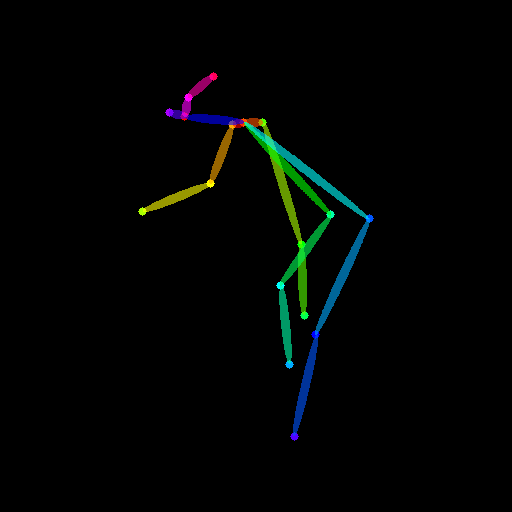

torch.Size([1, 3, 512, 512])


In [14]:
import os
import cv2
import time
import einops
from PIL import Image
# prompt_negative = ["deformation, ugly, bad quality, distortion"]

# lora_network.
# # total_model = Ensemble(model, lora_network, learning_rate, sd_locked, only_mid_control)
# lora_network.load_state_dict(lora_unet)
# total_model.lora.load_state_dict(lora_unet)
# prompt = ["1girl, aurora, blonde_hair, city_lights, cloud, cloudy_sky, diffraction_spikes, feather_hair_ornament, feathers, gradient_sky, hair_ornament, holding, horizon, illyasviel_von_einzbern, lens_flare, light_rays, long_hair, looking_at_viewer, ocean, orange_sky, outdoors, prisma_illya, red_eyes, shooting_star, sitting, sky, solo, sparkle, star_\\(sky\\), starry_sky, sun, sunlight, sunrise, sunset, twilight"]
prompt = ["masterpiece, best quality, seduction, cute face, 1girl, sexy, 8K, high resolution, weapon"]
prompt_negative = ["easynegative, lowres, text, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, bad anatomy, bad hands, error, missing fingers, extra digits, fewer digits, bad feet, bad colours, missing arms, text, water print, logo"]



# using pose root_dir/hint/1.png
hint_path = os.path.join(root_dir, 'hint', '16.png')
source = cv2.imread(hint_path)
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
display(Image.fromarray(source))
# require source shape to be the same as (height, width)

height = 512
width = 512
random_seed = time.time()

source = cv2.resize(source, (height, width), interpolation=cv2.INTER_LINEAR)
source = torch.tensor((source.astype(np.float32)/ 255.0)).to(torch_device).unsqueeze(0)
source = einops.rearrange(source, 'b h w c -> b c h w').clone()

print(source.shape)

# import random
# random_seed = random.randint(0, 2147483647)

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1



In [15]:
from utils.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning
import utils.prompt_parser
from modules.sampler import VanillaStableDiffusionSampler
from ldm.models.diffusion.ddim import DDIMSampler
from PIL import Image
%load_ext autoreload
%autoreload

# model.to(accelerator.device)
# LoraNet.to(torch_device)
# model.to(torch_device)

# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
# orig_sampler = VanillaStableDiffusionSampler(DDIMSampler, )
# lora_network.apply_to
orig_sampler = DDIMSampler(model)


# Positive Text Embedding
positive_text_embeddings = model.get_learned_conditioning(prompt)
print(f'the postive text embedding: {positive_text_embeddings}')

# Negative Text Embedding
negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
print(f'the negative text embedding: {negative_text_embeddings}')

# Prep latents
torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)

add_prompt = 'illya'

conditioning = {'c_crossattn': [positive_text_embeddings]}
conditioning['pose_1'] = [source]
unconditional_conditioning = {'c_crossattn': [negative_text_embeddings]}
unconditional_conditioning['pose_1'] = [source]

conditioning['pose_1_text'] = [model.get_learned_conditioning([f"{add_prompt}"])]
unconditional_conditioning['pose_1_text'] = [model.get_learned_conditioning([f"{add_prompt}"])]

                            #  unconditional_conditioning=negative_text_embeddings,
                            #  conditioning=positive_text_embeddings,
sample_ddim, intermediates = orig_sampler.sample(S=num_inference_steps, 
                             batch_size=1,
                             shape=(4, height // 8, width // 8),
                             conditioning=conditioning,
                             x_T=latents,
                             unconditional_conditioning=unconditional_conditioning,
                             unconditional_guidance_scale=cfg_scale)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
the postive text embedding: tensor([[[-0.3902,  0.0251, -0.0575,  ..., -0.4900, -0.2999,  0.0586],
         [-2.2167,  0.0847,  1.7907,  ..., -0.1975,  0.6685,  2.1359],
         [-1.0957,  0.1634,  2.2141,  ..., -0.4071,  0.8975,  1.4139],
         ...,
         [ 0.9588, -0.5327, -0.5269,  ..., -0.3192, -1.3475, -0.2952],
         [ 0.9563, -0.5214, -0.5376,  ..., -0.3220, -1.3470, -0.2934],
         [ 0.9931, -0.4091, -0.5625,  ..., -0.3327, -1.3182, -0.4059]]],
       device='cuda:0')
the negative text embedding: tensor([[[-0.3902,  0.0251, -0.0575,  ..., -0.4900, -0.2999,  0.0586],
         [ 0.0713,  0.1350,  1.5744,  ..., -0.0112,  1.2319, -0.6426],
         [-0.6670, -0.2492,  0.8781,  ..., -1.7046, -0.2594,  0.2287],
         ...,
         [-0.0339,  0.1595, -1.0516,  ..., -2.6092, -0.0613, -1.2767],
         [-0.0529,  0.1980, -1.0309,  ..., -2.6422, -0.0425, -1.3094],
         [-0.0912,  

DDIM Sampler: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


# New sampling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
cuda


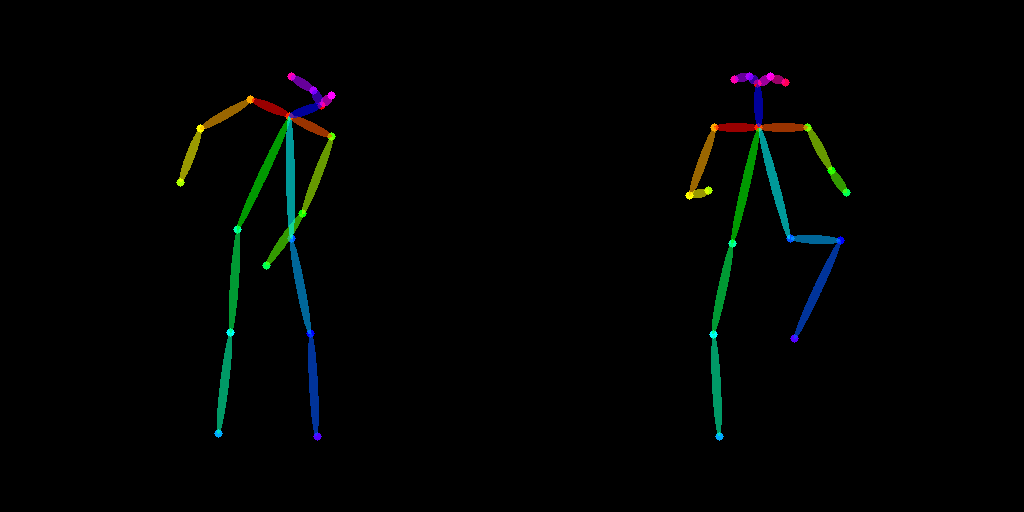

Selected timesteps for ddim sampler: [  1  26  51  76 101 126 151 176 201 226 251 276 301 326 351 376 401 426
 451 476 501 526 551 576 601 626 651 676 701 726 751 776 801 826 851 876
 901 926 951 976]
Selected alphas for ddim sampler: a_t: tensor([0.9985, 0.9756, 0.9507, 0.9229, 0.8931, 0.8608, 0.8262, 0.7900, 0.7520,
        0.7129, 0.6724, 0.6309, 0.5889, 0.5469, 0.5049, 0.4634, 0.4229, 0.3835,
        0.3455, 0.3093, 0.2749, 0.2428, 0.2128, 0.1851, 0.1598, 0.1368, 0.1163,
        0.0980, 0.0819, 0.0679, 0.0557, 0.0453, 0.0366, 0.0292, 0.0231, 0.0181,
        0.0140, 0.0107, 0.0082, 0.0061]); a_(t-1): [0.99902344 0.99853516 0.97558594 0.95068359 0.92285156 0.89306641
 0.86083984 0.82617188 0.79003906 0.75195312 0.71289062 0.67236328
 0.63085938 0.58886719 0.546875   0.50488281 0.46337891 0.42285156
 0.38354492 0.34545898 0.30932617 0.27490234 0.24279785 0.21276855
 0.18505859 0.15979004 0.13684082 0.11633301 0.09802246 0.08190918
 0.06787109 0.0557251  0.04534912 0.03656006 0.0291748

DDIM Sampler: 100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


In [17]:
from utils.prompt_parser import get_learned_conditioning, get_multicond_learned_conditioning
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from annotator.openpose import OpenposeDetector
from PIL import Image
import numpy as np
import os
import time, random
%load_ext autoreload
%autoreload

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from modules.sampler import VanillaStableDiffusionSampler

# webui_sampler = VanillaStableDiffusionSampler(DDIMSampler, model)
orig_sampler = DDIMSampler(model)



apply_canny = CannyDetector()
apply_openpose = OpenposeDetector()

torch_device = 'cuda'

model.to(torch_device)
# prompt = ["A cool digital illustration of a steampunk computer laboratory with clockwork machines, 4k, detailed, trending in artstation, fantasy vivid colors"]
# prompt_negative = [""]
# prompt = ["chisato, masterpiece, best quality, loli, animal ears, blue eyes, seduction, sea, wet,  cute face, long hair, white hair, 1girl, sexy,  8K, high resolution"]
# prompt = ["masterpiece, best quality, seduction, sea, wet, cute face, 1girl, sexy,  8K, high resolution"]
# prompt_negative = ["deformation, ugly, bad quality, distortion"]

prompt = ["2girls, masterpiece, best quality"]
prompt_negative = ["easynegative, lowres, text, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, bad anatomy, bad hands, error, missing fingers, extra digits, fewer digits, bad feet, bad colours, missing arms, text, water print, logo"]
random_seed = random.randint(0, 2147483647)

num_inference_steps = 40
cfg_scale = 7.5
batch_size = 1

# Positive Text Embedding
positive_text_embeddings = model.get_learned_conditioning(prompt) 
# print(f'the postive text embedding: {positive_text_embeddings}')

# Negative Text Embedding
negative_text_embeddings  = model.get_learned_conditioning(prompt_negative)
# print(f'the negative text embedding: {negative_text_embeddings}')

# Prep latents

root_dir = '/home/lolicon/workspace/dataset/Illya'
hint_path = os.path.join(root_dir, 'hint', '14.png')
source_1 = cv2.imread(hint_path)
source_1 = cv2.cvtColor(source_1, cv2.COLOR_BGR2RGB)
source_1 = cv2.resize(source_1, (512, 512))

root_dir = '/home/lolicon/workspace/dataset/takina'
hint_path = os.path.join(root_dir, 'hint', '6.png')
source_2 = cv2.imread(hint_path)
source_2 = cv2.cvtColor(source_2, cv2.COLOR_BGR2RGB)
source_2 = cv2.resize(source_2, (512, 512))

# require source shape to be the same as (height, width)

height = 512
width = 1024


source_1_ = np.zeros((height, width, 3), dtype=np.uint8)
source_1_[:, :512, :] += source_1


source_2_ = np.zeros((height, width, 3), dtype=np.uint8)
source_2_[:, 512:, :] += source_2

display(Image.fromarray(source_1_ + source_2_))



source_1_ = torch.tensor((source_1_.astype(np.float32) / 127.5 - 1.0)).to(torch_device).unsqueeze(0)
source_1_ = einops.rearrange(source_1_, 'b h w c -> b c h w').clone()


source_2_ = torch.tensor((source_2_.astype(np.float32) / 127.5 - 1.0)).to(torch_device).unsqueeze(0)
source_2_ = einops.rearrange(source_2_, 'b h w c -> b c h w').clone()


torch.manual_seed(random_seed)
latents = torch.randn((batch_size, 4, height // 8, width // 8), device='cpu')
latents = latents.to(torch_device)


conditioning={'c_crossattn': [positive_text_embeddings]}
unconditional_conditioning={'c_crossattn': [negative_text_embeddings]}

# def process_control(input_image, image_resolution, num_samples=1, low_threshold=100, high_threshold=200):
#     with torch.no_grad():
#         img = resize_image(HWC3(input_image), image_resolution)
#         H, W, C = img.shape

#         detected_map, _ = apply_openpose(img)
#         # detected_map = apply_canny(img, low_threshold, high_threshold)
#         detected_map = HWC3(detected_map)
#         print(detected_map.shape)
#         display(Image.fromarray(detected_map))
#         control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
#         control = torch.stack([control for _ in range(num_samples)], dim=0)
#         control = einops.rearrange(control, 'b h w c -> b c h w').clone()

#     return control

# # control_image = Image.open('./../../data/dataset/blue-archive/character/ブルーアーカイブ0- 2.jpg')
# control_image = Image.open('/home/lolicon/workspace/dataset/Illya/hint/1.png')
# display(control_image)
# canny_1 = process_control(np.array(control_image), image_resolution=512)

# add_prompt_1 = 'an illustration of takina'
# add_prompt_2 = 'an illustration of takina'


# add_prompt_1 = 'an illustration'
# add_prompt_2 = 'an illustration'


conditioning['pose_1'] = [source_1_]
# conditioning['pose_1_text'] = [model.get_learned_conditioning([f"{add_prompt_1}, " + prompt[0]])]

conditioning['pose_2'] = [source_2_]
# conditioning['pose_2_text'] = [model.get_learned_conditioning([f"{add_prompt_2}, " + prompt[0]])]


unconditional_conditioning['pose_1'] = [source_1_]
# unconditional_conditioning['pose_1_text'] = [negative_text_embeddings]
# unconditional_conditioning['pose_1_text'] = [model.get_learned_conditioning([f"{add_prompt_1}, " + prompt_negative[0]])]

unconditional_conditioning['pose_2'] = [source_2_]
# unconditional_conditioning['pose_2_text'] = [negative_text_embeddings]
# unconditional_conditioning['pose_2_text'] =  [model.get_learned_conditioning([f"{add_prompt_2}, " + prompt_negative[0]])]
# unconditional_conditioning['pose_1_text'] = ['illya']


for key in model.control_model.control_scales.keys():
    model.control_model.control_scales[key] = [0.6] * 13 

sample_ddim, intermediates = orig_sampler.sample(S=num_inference_steps, 
                             batch_size=1,
                             shape=(4, height // 8, width // 8),
                             conditioning=conditioning,
                             x_T=latents,
                             unconditional_conditioning=unconditional_conditioning,
                             unconditional_guidance_scale=cfg_scale)



# Show image

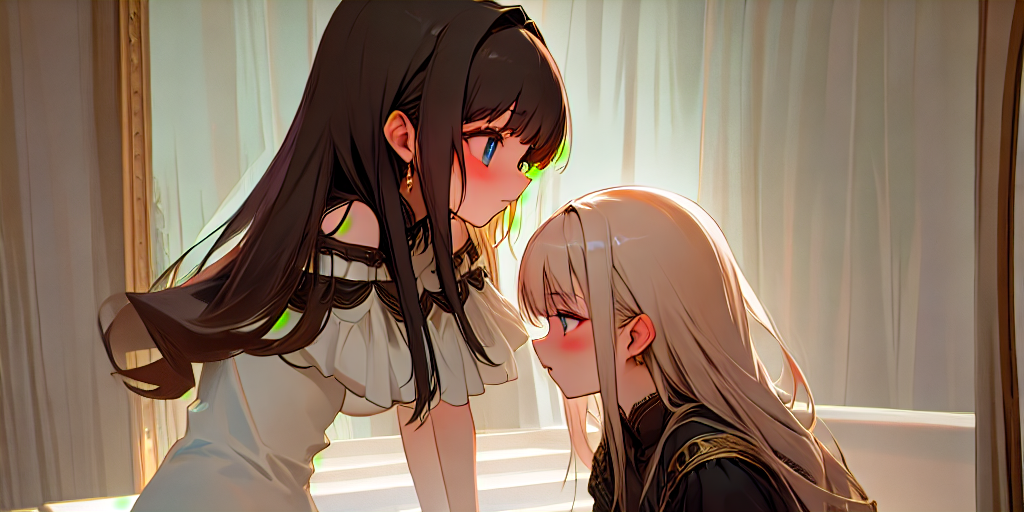

In [18]:
from PIL import Image
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


In [ ]:
image = model.decode_first_stage(sample_ddim)

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


In [ ]:

image = model.decode_first_stage(Lora_dataset[4][0].to(accelerator.device).unsqueeze(0))

# Display
image = (image / 2.0 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [26]:
# LoraNet.load_module()
# LoraNet.unload_module()

In [ ]:
import pytorch_lightning as pl
from ldm.util import log_txt_as_img, exists, default, ismap, isimage, mean_flat, count_params, instantiate_from_config
# Set the gradient

class trainModel(pl.LightningModule):
    def __init__(self, LDMmodel, LoraNet):
        super().__init__()
        self.model = LDMmodel
        self.LoraNet = LoraNet
    
    def set_gradient(self):
        self.model.first_stage_model = self.model.first_stage_model.to('cpu')
        self.model.requires_grad_(requires_grad=True)
        self.LoraNet.requires_grad_(requires_grad=True)
    
    def p_losses(self, x_start, t, cond, noise=None):
        
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.model.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model.model(x_noisy, t=t, c_crossattn=[cond])

        loss_dict = {}
        if self.model.parameterization == "eps":
            target = noise
        elif self.model.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(f"Paramterization {self.parameterization} not yet supported")

        loss = self.model.get_loss(model_out, target, mean=False).mean(dim=[1, 2, 3])

        log_prefix = 'train' if self.model.training else 'val'

        loss_dict.update({f'{log_prefix}/loss_simple': loss.mean()})
        loss_simple = loss.mean() * self.model.l_simple_weight

        loss_vlb = (self.model.lvlb_weights[t] * loss).mean()
        loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

        loss = loss_simple + self.model.original_elbo_weight * loss_vlb

        loss_dict.update({f'{log_prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, image, cond):
        # b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
        # assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        cond = self.model.get_learned_conditioning(cond)
        t = torch.randint(0, self.model.num_timesteps, (image.shape[0],), device=self.model.device).long()
        return self.p_losses(image, t, cond)


myModel = trainModel(model, LoraNet)

myModel.set_gradient()

